<a href="https://colab.research.google.com/github/eduardoplima/decisoes-lm/blob/main/decisoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso de LLMs para análise de decisões do Tribunal de Contas do Estado do Rio Grande do Norte

Os Tribunais de Contas possuem atribuições constitucionais diversas, que abrangem desde o julgamento de contas públicas à análise de atos de pessoal (tais como admissão e aposentadoria de servidores público). Seu colegiado, composto normalmente por sete conselheiros, tem o poder de determinar multas ou obrigações de fazer a gestores públicos responsáveis por órgãos jurisdicionados que descumpram normas legais ou conformidades operacionais.

No caso específico do Tribunal de Contas do Estado do Rio Grande do Norte, sua estrutura funcional, recém modificada, contempla uma diretoria cuja função é a gestão do exame, instrução e encaminhamentos referentes a processos de controle externo. Trata-se da Diretoria de Instrução Processual, cuja subunidade denominada Coordenadoria de Controle de Decisões (CCD) é responsável pelo cadastro, controle e monitoramento das obrigações decorrentes das decisões do TCE/RN e das recomendações de fiscalização e auditoria.

Também é da incumbência da CCD o criação do Cadastro Geral de Acompanhamento de Decisões (CGAD), conforme Art. 431 do Regimento Interno do TCE/RN. O referido cadastro inclui:

* Cadastro Geral de Multas (CGM), com acompanhamento permanente dos pagamentos
diretos ao Tribunal;
* Cadastro Geral de Devoluções (CGD), para acompanhamento permanente das condenações para devolução de valores ao Tesouro Estadual e aos Tesouros Municipais;
* Cadastro Geral de Recomendações (CGR), para acompanhamento permanente de todas as decisões para obrigação de fazer ou não fazer.
* Cadastro Geral de Termos de Ajustamento de Gestão (CGTAG), para acompanhamento dos Termos de Ajustamento de Gestão celebrados pelo Ministério Público junto ao Tribunal.

Esse notebook emprega técnicas de Reconhecimento de Entidades Nomeadas, _Word embeddings_ e LLMs para a criação dos cadastros mencionados.


In [ ]:
!pip install langchain_openai langchain_community gdown langgraph >> /dev/null

In [ ]:
import os
import getpass
import gdown

import pandas as pd

from langchain.prompts import PromptTemplate, ChatPromptTemplate, FewShotChatMessagePromptTemplate
from langchain_openai import OpenAI, ChatOpenAI

In [ ]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OPENAI_API_KEY:")

OPENAI_API_KEY:··········


# Dataset

O dataset utilizado é composto por decisões exaradas pelo TCE/RN no ano de 2024. Os processos do TCE/RN são compostos por informações. Cada informação representa eventos de um processo, tais como uma petição inicial, um relatório de auditoria, a juntada de um documento, ou, como o caso em tela, a decisão sobre o processo. O conjunto de dados disponível é uma lista de objetos JSON criada a partir da junção das tabelas processo e informação do banco de dados administrativo do TCE/RN. Cada objeto contém os seguintes campos:

* `numero_processo`
* `ano_processo`
* `setor`: o setor de origem da decisão, nesse caso, o gabinete do conselheiro responsável pela decisão;
* `codigo_tipo_processo`: o tipo de processo sobre o qual a decisão foi determinada. Um dataframe com as descrições de cada tipo é criado abaixo;
* `assunto`: descrição simples do processo;
* `resumo`: um resumo da informação de decisão cadastrada;
* `texto`: o texto completo de cada decisão, esse campo é obtido por meio da leitura de um arquivo pdf.

Foram mantidos no dataset apenas processos referentes a atuações do TCE/RN no controle externo, excluindo-se as decisões referentes a atos de pessoal (aposentadoria, admissão e pensão), assuntos administrativos e "outros". Esses assunto são tratados por outras diretorias na estrutura organizacional do TCE/RN (por exemplo, a Diretoria de Atos de Pessoal). Ademais, para esse experimento, só foram escolhidos processos recentes (2021 em diante).

In [ ]:
url = "https://raw.githubusercontent.com/eduardoplima/decisoes-lm/refs/heads/main/dataset.json"
output = "dataset.json"
gdown.download(url, output)

url = "https://raw.githubusercontent.com/eduardoplima/decisoes-lm/refs/heads/main/tipos_processos.csv"
output = "tipos_processos.csv"
gdown.download(url, output)

Downloading...
From: https://raw.githubusercontent.com/eduardoplima/decisoes-lm/refs/heads/main/dataset.json
To: /content/dataset.json
1.20MB [00:00, 104MB/s]                   
Downloading...
From: https://raw.githubusercontent.com/eduardoplima/decisoes-lm/refs/heads/main/tipos_processos.csv
To: /content/tipos_processos.csv
15.7kB [00:00, 11.3MB/s]                   


'tipos_processos.csv'

In [ ]:
tipos = pd.read_csv("tipos_processos.csv")

In [ ]:
df = pd.read_json("dataset.json")

In [ ]:
len(df)

336

In [ ]:
df.head()

,numero_processo,ano_processo,codigo_tipo_processo,assunto,setor,resumo,data_resumo,arquivo,texto
0,200090,2021,APR,INADIMPLÊNCIA NA REMESSA DE SIAI DP NOVO ...,secpc,ACÓRDÃO PADRÃO,2024-02-05,secpc_200090_2021_0043.pdf,[Processo Nº 200090 / 2021 - TC (200090/2021-T...
1,200161,2022,CGE,INADIMPLÊNCIA NA REMESSA DE CONTAS ANUAIS DE G...,secsc,ACÓRDÃO PADRÃO,2024-01-17,secsc_200161_2022_0021.pdf,[Processo Nº 200161 / 2022 - TC (200161/2022-C...
2,907,2022,ACO,ACOMPANHAMENTO DE ACUMULAÇÃO DE CARGOS PÚBLICO...,secsc,ACÓRDÃO PADRÃO,2024-02-07,secsc_000907_2022_0041.pdf,[Processo Nº 000907 / 2022 - TC (000907/2022-T...
3,1264,2022,REP,REPRESENTAÇÃO EM FACE DE CONTRATAÇÕES TEMPORÁR...,secpc,ACÓRDÃO PADRÃO,2024-02-08,secpc_001264_2022_0051.pdf,[Processo Nº 001264 / 2022 - TC (001264/2022-T...
4,3101,2022,DEN,xxx ...,secsc,ACÓRDÃO PADRÃO,2024-01-25,secsc_003101_2022_0015.pdf,[Processo Nº 003101 / 2022 - TC (003101/2022-T...


O texto vem separado em uma lista, cujos índices representam páginas do pdf. Nós agrupamos a string a seguir.

In [ ]:
df['texto'] = df['texto'].apply(lambda x: ''.join(x))

Em uma análise preliminar percebe-se que as decisões seguem padrões bem diferentes. Por exemplo, abaixo se vê uma determinação de multa. Não há padronização nos campos, ou sequer uma indicação da categoria da decisão.

In [ ]:
print(df.iloc[15].texto)

Processo Nº 200158 / 2021 - TC (200158/2021-TC)
SESSÃO ORDINÁRIA 00046ª, DE 19 DE DEZEMBRO DE 2023 - 2ª CÂMARA.
Interessado(s):   URBANA - COMPANHIA DE SERVIÇOS URBANOS DE NATAL, POR SEU ATUAL 
GESTOR - CPF:08498701000104
  
Assunto:  INADIMPLÊNCIA NA REMESSA DE CONTAS ANUAIS DE GESTÃO
Responsável(is):  Jonny Araujo da Costa - CPF:20119178400 Joseildes Medeiros da Silva - 
CPF:22127909453
Relator(a):  MARIA ADÉLIA SALES
EMENTA: ATRASO NA PRESTAÇÃO DAS CONTAS ANUAIS DE GESTÃO . 
PREJUÍZOS DIRETOS À ATIVIDADE FISCALIZATÓRIA DESTA CORTE . 
DEFESA INCONSISTENTE. ATRASO CONFIGURADO. IRREGULARIDADE DA 
MATÉRIA, NOS TERMOS DO ART. 75, I, DA LCE Nº 464/2012. MULTA AO 
GESTOR RESPONSÁVEL QUE SE ENCONTRA V A OBRIGADO A APRESENTAR 
AS CONTAS NA DATA DO SEU VENCIMENTO, NOS MOLDES DO ART. 107, II, 
“A” E “B”, DA LCE Nº 464/2012 C/C ART. 21, I, “B” E § 2º, DA RESOLUÇÃO Nº 
012/2016-TCE.
ACÓRDÃO No. 340/2023 - TC
               Vistos, relatados e discutidos estes autos,  concordando com o Corpo Inst

Abaixo um exemplo de obrigação.

In [ ]:
print(df.iloc[20].texto)

Processo Nº 001231 / 2023 - TC (001231/2023-TC)
SESSÃO ORDINÁRIA 00004ª, DE 15 DE FEVEREIRO DE 2024 - 1ª CÂMARA.
Interessado(s):   PREFEITURA MUNICIPAL DE NÍSIA FLORESTA/RN                                                                                                                                                                                                                      
  
Assunto:  DENÚNCIA
Relator(a):  MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO
EMENTA: DENÚNCIA. AUSÊNCIA DE LASTRO PROBATÓRIO MÍNIMO PARA 
O DESENVOLVIMENTO REGULAR DO PROCESSO.  ADMISSIBILIDADE 
PREJUDICADA. INTELIGÊNCIA DO ARTIGO 80, § 1º, DA LOTCE . 
ARQUIV AMENTO DO PRESENTE FEITO.
ACÓRDÃO No. 40/2024 - TC
               Vistos, relatados e discutidos estes autos, em consonância ao posicionamento do 
Corpo técnico e do Ministério Público de Contas, ACORDAM os Conselheiros, nos termos 
do voto proposto pelo Conselheiro Relator, julgar a inadmissibilidade da presente denúncia e 
o seu conseqüente arquivamen

Por fim, abaixo vemos um exemplo de Termo de Ajustamento de Gestão. O instrumento também cria uma obrigação.

In [ ]:
print(df[df.codigo_tipo_processo == 'TAG'].iloc[0].texto)

Processo Nº 002056 / 2023 - TC (002056/2023-TC)
SESSÃO ORDINÁRIA 00055ª, DE 06 DE AGOSTO DE 2024 - PLENO.
Interessado(s):   MINISTÉRIO PÚBLICO DE CONTAS DO RN                                                                                                                                                                                                                             
  
Assunto:  TERMO DE AJUSTAMENTO DE GESTÃO 001/2023
Relator(a):  PAULO ROBERTO CHA VES ALVES
EMENTA: TERMO DE AJUSTAMENTO DE GESTÃO. HOMOLOGAÇÃO. 
DEFERIMENTO. 
1. TERMO DE AJUSTAMENTO DE GESTÃO COM ESCOPO DE REALIZAÇÃO 
DE CONCURSO PÚBLICO PARA CRIAÇÃO E PROVIMENTO DE 180 (CENTO E 
OITENTA) CARGOS EFETIVOS NO IDEMA, EM SUBSTITUIÇÃO A AGENTES 
VINCULADOS DE FORMA PRECÁRIA POR MEIO DE BOLSA DE PESQUISA.
2. PREENCHIMENTO DOS REQUISITOS EXIGIDOS PELA LEI ORGÂNICA E 
REGIMENTO INTERNO. HOMOLOGAÇÃO NOS TERMOS DO ART. 122, §3º, DA 
LEI COMPLEMENTAR Nº 464/2012.
ACÓRDÃO No. 328/2024 - TC
               Vistos, relatado

# LLMs

Nessa seção configuramos os modelos de LLM que vamos utilizar nas seções seguintes

In [ ]:
llm = ChatOpenAI(temperature=0, model_name='gpt-4o')

In [ ]:
print(llm)

client=<openai.resources.chat.completions.Completions object at 0x79b526956020> async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x79b526998850> root_client=<openai.OpenAI object at 0x79b525b0f6d0> root_async_client=<openai.AsyncOpenAI object at 0x79b526956800> model_name='gpt-4o' temperature=0.0 model_kwargs={} openai_api_key=SecretStr('**********')


# Classificação de Texto

A classificação de textos é uma tarefa fundamental no campo do Processamento de Linguagem Natural (PLN), onde o objetivo é categorizar automaticamente documentos ou trechos de texto em classes predefinidas. Essa tarefa é amplamente aplicada em diversos contextos, como análise de sentimentos, categorização de notícias, detecção de spam, e sistemas de recomendação.

A análise preliminar demonstrou a necessidade de primeiro definir se há uma multa ou obrigação envolvida na decisão. Após isso, devemos extrair os elementos pertinentes. Desse modo, vamos utilizar LLMs para cada uma das tarefas diferentes na nossa linha de produção. Primeiro definimos o tipo do nosso texto e depois extraímos os elementos correspondentes a nossa classificação.

Iremos utilizar uma estratégia Few Shot Learning para a classificação.


In [ ]:
def classify_decision(state):
  examples = [
      {
          "input": """
          - Adoção das providências cabíveis no tocante aos indícios de impropriedades /irregularidades
  elencadas na tabela 19 do Relatório (transcritas acima ), com fundamento no art. 2º, inciso III, da
  Resolução nº 012/2023-TCE, notadamente para que a Secretaria de Controle Externo analise a
  capacidade operacional desta Corte com vistas ao acompanhamento e /ou à abertura de processo
  autônomo, respeitadas a conveniência e oportunidade, referente aos itens 4.2 (Divergência dos
  dados do planejamento do Projeto, Inconsistência dos saldos da conta bens móveis entre os
  registros do SIGEF - Sistema Integrado de Planejamento e Gestão Fiscal - e SMI - Sistema de
  Monitoramento e Informações do Projeto - e deficiências na elaboração das notas explicativas ),
  5.5.1.1 (Inventário físico ), 5.6.1.1 ( Falhas/deficiências construtivas do Hospital Regional da
  Mulher Parteira Maria Correia) e 5.6.1.3 (Pendências de legalização das obras da Biblioteca
  Câmara Cascudo e da Sede do Serviço Nacional de Emprego – SINE).""",
          "output": "DETERMINACAO"}, {
          "input": """( a.i) promovam, no prazo de 120 (cento e vinte dias) úteis, contados a partir da intimação da
  presente Decisão, a apuração dos fatos e se verifique a constitucionalidade e legalidade dos
  vínculos funcionais de cada servidor que figura nos Anexos nºs. 01 e 02 contidos nos Eventos
  nºs. 04 e 05, além de outros que porventura sejam informados pela DDP em cumprimento ao
  item b, por meio da instauração de processos administrativos disciplinares individuais ,
  regulados pela Lei que trata do Estatuto Jurídico dos Servidores do respectivo Município ,
  com observância dos princípios do contraditório, ampla defesa e devido processo legal;
    ( a.ii) comprovem neste feito, em 05 dias úteis após ultimado o prazo de definição dos PAD
  ´s, as conclusões de todos os processos administrativos instaurados, no tocante à eliminação
  de tríplice vínculo funcional identificado e de enquadramento das eventuais acumulações
  dúplices nas hipóteses permitidas pela Constituição Federal, com a respectiva
  compatibilidade de horários, sob pena de, não cumprindo tais obrigações nos prazos antes
  referidos, incidir em multa diária e pessoal ao gestor, no valor de R$ 500,00, com espeque no
  art. 110 da LCE nº 464/2012 c/c o art. 326 do RITCE, cabendo à Diretoria de Despesa com
  Pessoal monitorar o cumprimento da presente Decisão;""",
          "output": "DETERMINACAO"}, {
          "input": """Vistos, relatados e discutidos estes autos, em consonância ao posicionamento do
  Corpo técnico e do Ministério Público de Contas, ACORDAM os Conselheiros, nos termos
  do voto proposto pelo Conselheiro Relator, julgar a inadmissibilidade da presente denúncia e
  o seu conseqüente arquivamento, com fulcro nos art. 12 do Provimento 002/2020 –
  CORREG/TCE, aprovado pela Resolução 016/2020 – TCE e artigo 80, § 1º, da LOTCE.
  E ainda, Pela expedição de RECOMENDAÇÃO, nos termos do art. 301, III da Resolução
  009/2012 (RITCE/RN) c/c art. 13, II da Resolução 16/2020 –TCE/RN, ao Executivo
  Municipal de Nísia Floresta /RN, com cópia para o respectivo órgão de controle interno, ou
  setor responsável pelas publicações oficiais, lastreada na Constituição Federal de 88/ Art. 37,
  a fim de que promova e deixe claro os seguintes comportamentos em suas postagens""",
          "output": "DETERMINACAO"},{
          "input": """Vistos, relatados e discutidos estes autos, concordando com o proposto pelo Corpo
  Técnico e pelo órgão Ministerial de Contas, ACORDAM os Conselheiros, nos termos do voto
  proferido pelo Conselheiro Relator, julgar pela irregularidade da matéria, nos termos do art .
  75, inciso I, da Lei Complementar nº 464/2012, condenando o gestor responsável, Sr. Thiago
  Meira Mangueira, ao pagamento de multa no valor de R$ 18.774,51 (dezoito mil setecentos e
  setenta e quatro reais e cinquenta e um centavos ), conforme previsto no art. 21, inciso I ,
  alínea ‘a’ e § 1º, da Resolução nº 012/2016-TCE c /c o art. 107, inciso II, alínea “a” da Lei
  Complementar nº 464/2012. """,
          "output": "DETERMINACAO"},
          {
              "input": """Vistos, relatados e discutidos estes autos, acolhendo os fundamentos do parecer
  ministerial, com substrato no art. 209 V da norma regimental, ACORDAM os Conselheiros ,
  nos termos do voto proposto pela Conselheira Relatora, julgar pelo ARQUIVAMENTO dos
  autos.""",
              "output": "OUTROS",
          },
          {
              "input": """Vistos, relatados e discutidos estes autos, ACORDAM os Conselheiros,  com o
  impedimento do Conselheiro Presidente Renato Costa Dias, nos termos do voto profposto
  pela Conselheira Relatora, haja vista os fundamentos fático -jurídicos explanados no excerto
  antecedente, comprovado documentalmente o adimplemento substancial do plano de
  redimensionamento/adequação do sistema de ensino natalense, julgar pela EXTINÇÃO do
  FEITO nos termos do art. 71 da Lei Complementar (estadual) c/c art. 22 §1° da LINDB e art .
  209 V da regra regimental.""",
              "output": "OUTROS",
          },
          {
              "input": """Vistos, relatados e discutidos estes autos, em consonância com o posicionamento da
  Diretoria de Administração Municipal – DAM e do Ministério Público de Contas ,
  ACORDAM os Conselheiros, nos termos do voto proferido pelo Conselheiro Relator, julgar
  pelo reconhecimento da incidência da Prescrição Intercorrente sobre a pretensão punitiva e
  ressarcitória desta Corte de Contas, nos termos do artigo 111, parágrafo único, da Lei
  Complementar Estadual nº 464/2012, com o consequente arquivamento dos presentes autos.
  E ainda, pelo envio de cópia das principais peças dos autos ao Ministério Público Estadual ,
  para conhecimento e atuação no âmbito de sua competência.""",
              "output": "OUTROS",
          },
          {
              "input": """Vistos, relatados e discutidos estes autos, em dissonância com o Ministério Público
  de Contas, ACORDAM os Conselheiros, nos termos do voto proferido pelo Conselheiro
  Relator, julgar pela extinção do feito, sem julgamento de mérito, com o consequente
  ARQUIV AMENTO dos autos, em virtude da incompatibilidade entre a emissão de parecer
  prévio pela aprovação com ressalvas das contas de governo e a instauração de apuração de
  responsabilidade para aplicação de sanções.""",
              "output": "OUTROS",
          }
  ]

  example_prompt = ChatPromptTemplate.from_messages([
        ("human", '''
         {input} '''),
        ("ai", "{output}"),
    ])

  few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,)

  final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """Você é um classificador de decisões de um tribunal de contas.
         Sua tarefa é definir se uma decisão trata de uma multa ou obrigação
         de fazer.

         Responda com DETERMINACAO se o texto contiver o termo "multa" e alguma recomendação ou obrigação de fazer
         Responda com OUTROS se o texto tratar de arquivamento, extinção do feito ou prescrição da matéria, ou outro assunto que não seja DETERMINACAO

         Responda APENAS com DETERMINACAO ou OUTROS."""),
        few_shot_prompt,
        ("human", "{input}"),])

  chain = final_prompt | llm
  decision_type = chain.invoke({"input": state["messages"]}).content
  state['messages'] = state['messages'] + [decision_type]
  return state


Realizamos alguns testes para verificar a eficácia do modelo. Nos casos apresentados, o modelo acerta a categoria de decisão.

In [ ]:
classify_decision({'messages': [df.iloc[1].texto]})

In [ ]:
print(df.iloc[1].texto)

Processo Nº 200161 / 2022 - TC (200161/2022-CPRSASSU)
SESSÃO ORDINÁRIA 00046ª, DE 19 DE DEZEMBRO DE 2023 - 2ª CÂMARA.
Interessado(s):   CONSORCIO PUBLICO REGIONAL DE SANEAMENTO BASICO DO V ALE DO 
RN, POR SEU ATUAL GESTOR - CPF:18578201000136
  
Assunto:  INADIMPLÊNCIA NA REMESSA DE CONTAS ANUAIS DE GESTÃO
Responsável(is):  THIAGO MEIRA MANGUEIRA - CPF:03181889458
Relator(a):  PAULO ROBERTO CHA VES ALVES
EMENTA: CONTAS DE GESTÃO DO EXERCÍCIO DE 2021.OMISSÃO NA 
ENTREGA. REVELIA IRREGULARIDADE DAS CONTAS COM APLICAÇÃO DE 
MULTA E FIXAÇÃO DE OBRIGAÇÃO DE FAZER.
ACÓRDÃO No. 337/2023 - TC
               Vistos, relatados e discutidos estes autos, concordando com o proposto pelo Corpo 
Técnico e pelo órgão Ministerial de Contas, ACORDAM os Conselheiros, nos termos do voto 
proferido pelo Conselheiro Relator, julgar pela irregularidade da matéria, nos termos do art . 
75, inciso I, da Lei Complementar nº 464/2012, condenando o gestor responsável, Sr. Thiago 
Meira Mangueira, ao pagamento de 

In [ ]:
classify_decision({'messages': [df.iloc[0].texto]})

{'messages': ['Processo Nº 200090 / 2021 - TC (200090/2021-TC)\nSESSÃO ORDINÁRIA 00002ª, DE 01 DE FEVEREIRO DE 2024 - 1ª CÂMARA.\nInteressado(s):   PREFEITURA MUNICIPAL DE IELMO MARINHO, POR SEU GESTOR ATUAL - \nCPF:08004525000107\n  \nAssunto:  INADIMPLÊNCIA NA REMESSA DE SIAI DP NOVO\nApuração de responsabilidade.\nResponsável(is):  ROSSANE MARQUES LIMA PATRIOTA - CPF:06557099400\nRelator(a):  ANA PAULA DE OLIVEIRA GOMES\nEMENTA: APURAÇÃO DE RESPONSABILIDADE. PRESTAÇÃO DE \nINFORMAÇÕES. QUITAÇÃO DA RESPONSÁVEL. ARQUIVAMENTO DO \nFEITO.\nACÓRDÃO No. 15/2024 - TC\n               Vistos, relatados e discutidos estes autos, ACORDAM os Conselheiros, nos termos \ndo voto proposto pela Conselheira Relatora, haja vista o teor do parecer 23/2023, com \nfundamento no art. 73 da LC 464/2012 c/c art. 22 §§ 1° e 2° da LINDB, julgar  pela aprovação \nda matéria, quitação do responsável e arquivamento do caderno. Precedente utilizado : \nprocesso 200094/2021 – acórdão 21/2023.\nFinalmente, pela amp

In [ ]:
print(df.iloc[0].texto)

Processo Nº 200090 / 2021 - TC (200090/2021-TC)
SESSÃO ORDINÁRIA 00002ª, DE 01 DE FEVEREIRO DE 2024 - 1ª CÂMARA.
Interessado(s):   PREFEITURA MUNICIPAL DE IELMO MARINHO, POR SEU GESTOR ATUAL - 
CPF:08004525000107
  
Assunto:  INADIMPLÊNCIA NA REMESSA DE SIAI DP NOVO
Apuração de responsabilidade.
Responsável(is):  ROSSANE MARQUES LIMA PATRIOTA - CPF:06557099400
Relator(a):  ANA PAULA DE OLIVEIRA GOMES
EMENTA: APURAÇÃO DE RESPONSABILIDADE. PRESTAÇÃO DE 
INFORMAÇÕES. QUITAÇÃO DA RESPONSÁVEL. ARQUIVAMENTO DO 
FEITO.
ACÓRDÃO No. 15/2024 - TC
               Vistos, relatados e discutidos estes autos, ACORDAM os Conselheiros, nos termos 
do voto proposto pela Conselheira Relatora, haja vista o teor do parecer 23/2023, com 
fundamento no art. 73 da LC 464/2012 c/c art. 22 §§ 1° e 2° da LINDB, julgar  pela aprovação 
da matéria, quitação do responsável e arquivamento do caderno. Precedente utilizado : 
processo 200094/2021 – acórdão 21/2023.
Finalmente, pela ampla divulgação do que for decidido

# Extração de dados

Reconhecidas as categorias, temos que extrair as informações úteis para o cadastro de multas e o cadastro de recomendações. Primeiro criamos um classe de dados para essas informações e depois utilizamos nosso modelo para extraí-las.

Aqui ressaltamos que uma decisão pode conter várias determinações, e cada uma pode ser uma multa ou uma obrigação. Desse modo, inicialmente, é necessário identificar as determinações de uma decisão para então extrair as informações úteis.

In [ ]:
from typing import Optional, List

from pydantic import BaseModel, Field

class Multa(BaseModel):
  """Determinação de multa, com valor e responsável"""
  responsavel: str = Field(description="Nome do responsável pela multa")
  valor: float = Field(description="Valor da multa")

class Obrigacao(BaseModel):
  """Determinação de obrigação, com valor e responsável"""
  responsavel: str = Field(description="Nome do órgão ou gestor responsável pela obrigação")
  descricao: str = Field(description="Texto descritivo da obrigação")

class Decisao(BaseModel):
  """Decisão processual do TCE/RN"""
  determinacao: List[Optional[Multa | Obrigacao]] = Field(description="Determinação de multa ou obrigação")



In [ ]:
def identify_decision(state):
  prompt = PromptTemplate.from_template("""
  Você é um agente que identifica listas de determinações em textos de decisões. Seu objetivo
  é extrair um conjunto de textos de uma lista que contém obrigações ou imposições de multas. Se não houver
  determinações, responda apenas com "N/D"

  Decisão : {input}

  Sua resposta:
  """)

  structured_llm = llm.with_structured_output(schema=Decisao)
  chain = prompt | structured_llm
  response = chain.invoke(state['messages'])
  state['messages'] = state['messages'] + [response]
  return state

In [ ]:
d = identify_decision({'messages': [df.iloc[1].texto]})

In [ ]:
'determinacao' in d['messages'][-1].__dict__

True

In [ ]:
d['messages'][-1].determinacao[0]

Multa(responsavel='Thiago Meira Mangueira', valor=18774.51)

In [ ]:
print(df.iloc[1].texto)

Processo Nº 200161 / 2022 - TC (200161/2022-CPRSASSU)
SESSÃO ORDINÁRIA 00046ª, DE 19 DE DEZEMBRO DE 2023 - 2ª CÂMARA.
Interessado(s):   CONSORCIO PUBLICO REGIONAL DE SANEAMENTO BASICO DO V ALE DO 
RN, POR SEU ATUAL GESTOR - CPF:18578201000136
  
Assunto:  INADIMPLÊNCIA NA REMESSA DE CONTAS ANUAIS DE GESTÃO
Responsável(is):  THIAGO MEIRA MANGUEIRA - CPF:03181889458
Relator(a):  PAULO ROBERTO CHA VES ALVES
EMENTA: CONTAS DE GESTÃO DO EXERCÍCIO DE 2021.OMISSÃO NA 
ENTREGA. REVELIA IRREGULARIDADE DAS CONTAS COM APLICAÇÃO DE 
MULTA E FIXAÇÃO DE OBRIGAÇÃO DE FAZER.
ACÓRDÃO No. 337/2023 - TC
               Vistos, relatados e discutidos estes autos, concordando com o proposto pelo Corpo 
Técnico e pelo órgão Ministerial de Contas, ACORDAM os Conselheiros, nos termos do voto 
proferido pelo Conselheiro Relator, julgar pela irregularidade da matéria, nos termos do art . 
75, inciso I, da Lei Complementar nº 464/2012, condenando o gestor responsável, Sr. Thiago 
Meira Mangueira, ao pagamento de 

É possível ver que o LLM é bem-sucedido na extração de informações estruturadas de decisões. O próximo passo é verificar as informações e complementá-las com bases de dados externas.

# Tool Calling

O TCE/RN possui bancos de dados sensíveis referentes a informações de pessoas físicas e jurídicas, tais como bCPF e bCNPJ (oriundos da plataforma bCadastros disponibilizada pelo SERPRO), assim como DETRAN e IPTU (úteis para a verificação de existência de bens em caso de devedores inadimplentes). Dessa forma, em uma implementação final, nosso agente será capaz de fornecer informações complementares à saída do nosso agente. Por enquanto, iremos _mockar_ a busca por CPF reconhecimento em uma decisão por multa. A função será então chamada via `tool calling` por nosso modelo.

In [ ]:
from langchain_core.tools import StructuredTool

def search_pessoa(nome):
  """Procura dados de uma pessoa"""
  return {
    'nome': nome,
    'endereço': 'Av Tal, Bairro Bem Ali, nº 1',
    'telefone': '84123456789'
  }

search_pessoa_tool = StructuredTool.from_function(func=search_pessoa, parse_docstring=True, )


In [ ]:
search_pessoa_tool.to_json()

{'lc': 1,
 'type': 'not_implemented',
 'id': ['langchain_core', 'tools', 'structured', 'StructuredTool'],
 'repr': "StructuredTool(name='search_pessoa', description='Procura dados de uma pessoa', args_schema=<class 'langchain_core.utils.pydantic.search_pessoa'>, func=<function search_pessoa at 0x79b525b6bf40>)",
 'name': 'search_pessoa'}

In [ ]:
llm_with_tools = llm.bind_tools([search_pessoa_tool])

In [ ]:
response = identify_decision({'messages': df.iloc[1].texto})

In [ ]:
response['determinacoes'].determinacao[0]

Multa(responsavel='Thiago Meira Mangueira', valor=18774.51)

In [ ]:
response = llm_with_tools.invoke(str(response['determinacoes'].determinacao[0].responsavel))

In [ ]:
response.tool_calls

[{'name': 'search_pessoa',
  'args': {'nome': 'Thiago Meira Mangueira'},
  'id': 'call_cvJQGz0DTeyzAvEib6Cb1x69',
  'type': 'tool_call'}]

# Criação de um agente

Criadas as funções que extraem as informações pertinentes, esses componentes podem ser agrupados em um agente. Nos trechos de códigos a seguir vemos a construção de um agente por meio da ferramenta langgraph. Cada função apresentada de forma separada é unida em um grafo, cujo resultado final é o texto devidamente classificado, com suas determinações e pessoas envolvidadas identificadas.

In [ ]:
texto = df.iloc[1].texto

In [ ]:
print(texto)

Processo Nº 200161 / 2022 - TC (200161/2022-CPRSASSU)
SESSÃO ORDINÁRIA 00046ª, DE 19 DE DEZEMBRO DE 2023 - 2ª CÂMARA.
Interessado(s):   CONSORCIO PUBLICO REGIONAL DE SANEAMENTO BASICO DO V ALE DO 
RN, POR SEU ATUAL GESTOR - CPF:18578201000136
  
Assunto:  INADIMPLÊNCIA NA REMESSA DE CONTAS ANUAIS DE GESTÃO
Responsável(is):  THIAGO MEIRA MANGUEIRA - CPF:03181889458
Relator(a):  PAULO ROBERTO CHA VES ALVES
EMENTA: CONTAS DE GESTÃO DO EXERCÍCIO DE 2021.OMISSÃO NA 
ENTREGA. REVELIA IRREGULARIDADE DAS CONTAS COM APLICAÇÃO DE 
MULTA E FIXAÇÃO DE OBRIGAÇÃO DE FAZER.
ACÓRDÃO No. 337/2023 - TC
               Vistos, relatados e discutidos estes autos, concordando com o proposto pelo Corpo 
Técnico e pelo órgão Ministerial de Contas, ACORDAM os Conselheiros, nos termos do voto 
proferido pelo Conselheiro Relator, julgar pela irregularidade da matéria, nos termos do art . 
75, inciso I, da Lei Complementar nº 464/2012, condenando o gestor responsável, Sr. Thiago 
Meira Mangueira, ao pagamento de 

In [ ]:
from langgraph.prebuilt  import ToolNode

tool_node = ToolNode([search_pessoa_tool])

In [ ]:
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [ ]:
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolInvocation

def should_continue_classify(state):
    if not state['messages'][-1]:
        return "end"
    else:
        return "continue"

def should_continue_identify(state):
    if not state['messages'][-1] == 'DETERMINACAO':
        return "end"
    else:
        return "continue"

def call_model(state):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return response

def call_tool(state):
  print(state['messages'][-1].__dict__.keys())
  if 'determinacao' in state['messages'][-1].__dict__.keys():
    for determinacao in state['messages'][-1].determinacao:
      if not determinacao.responsavel:
        continue
      response = llm_with_tools.invoke(str(determinacao.responsavel))
      print(response)
      response = tool_node.invoke({'messages': [response]})
      state['messages'] = state['messages'] + [response['messages']]
      return state


In [ ]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)
workflow.add_node("classify", classify_decision)
workflow.add_node("identify", identify_decision)
workflow.add_node("search", call_tool)
workflow.add_edge(START, "classify")
workflow.add_edge("search", END)

workflow.add_conditional_edges(
    "classify",
    should_continue_classify,
    {
        "continue": "identify",
        "end": END,
    },
)

workflow.add_conditional_edges(
    "identify",
    should_continue_classify,
    {
        "continue": "search",
        "end": END,
    },
)

app = workflow.compile()

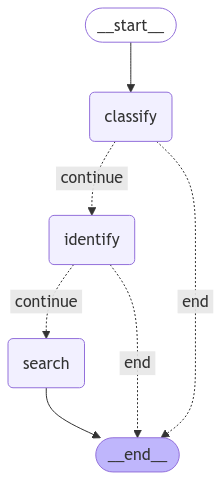

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle

try:
    graph_image = app.get_graph(xray=True).draw_mermaid_png(curve_style=CurveStyle.NATURAL)
    display(Image(graph_image))
except Exception as e:
    print(e)

In [ ]:
inputs = {"messages": [df.iloc[1].texto]}
result = app.invoke(inputs)

In [ ]:
result

{'messages': ['Processo Nº 200161 / 2022 - TC (200161/2022-CPRSASSU)\nSESSÃO ORDINÁRIA 00046ª, DE 19 DE DEZEMBRO DE 2023 - 2ª CÂMARA.\nInteressado(s):   CONSORCIO PUBLICO REGIONAL DE SANEAMENTO BASICO DO V ALE DO \nRN, POR SEU ATUAL GESTOR - CPF:18578201000136\n  \nAssunto:  INADIMPLÊNCIA NA REMESSA DE CONTAS ANUAIS DE GESTÃO\nResponsável(is):  THIAGO MEIRA MANGUEIRA - CPF:03181889458\nRelator(a):  PAULO ROBERTO CHA VES ALVES\nEMENTA: CONTAS DE GESTÃO DO EXERCÍCIO DE 2021.OMISSÃO NA \nENTREGA. REVELIA IRREGULARIDADE DAS CONTAS COM APLICAÇÃO DE \nMULTA E FIXAÇÃO DE OBRIGAÇÃO DE FAZER.\nACÓRDÃO No. 337/2023 - TC\n               Vistos, relatados e discutidos estes autos, concordando com o proposto pelo Corpo \nTécnico e pelo órgão Ministerial de Contas, ACORDAM os Conselheiros, nos termos do voto \nproferido pelo Conselheiro Relator, julgar pela irregularidade da matéria, nos termos do art . \n75, inciso I, da Lei Complementar nº 464/2012, condenando o gestor responsável, Sr. Thiago \nMe

# Conclusão

O presente trabalho demonstrou o uso promissor de Modelos Grandes de Linguagem (LLM) para a identificação de determinações de decisões de um Tribunal de Contas, assim como a extração de informações estruturadas dessas determinações.
A tecnologia empregada será de grande utilidade no caso do Tribunal de Contas do Estado do Rio Grande do Norte. Os cadastros de informações mencionados na introdução do notebook serão criados a partir do emprego das técnicas aqui apresentadas, poupando muitas horas de trabalho de codificação em abordagens tradicionais (uso de expressões regulares ou modelos supervisionados de aprendizado de máquina).